# Optional: Batch Normalization & Dropout 

In this Notebook we will introduce the idea of Batch Normalization and Dropout and how both these methods help in Neural Network training. 

By completing this exercise you will:
1. Know the implementation details of Batch Norm and Dropout
2. Notice the difference in behaviour during train and test time
3. Use Batch Norm and Dropout in a Fully Connected Layer to see how it affects training

Let us start with Batch Normalization:

# 1. Batch Normalization

## 1.1 What is Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was proposed by [1].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

### Before We Start

It is important that we take a look at the Mathematical formula behind Batch Norm. Please make sure to understand the formula below since this will definitely help you with the implementation later. :)

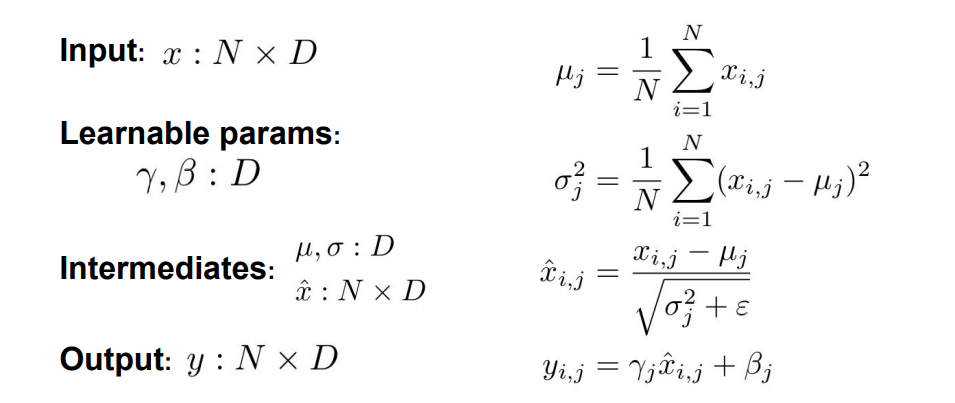

### A quick explanation of the formula
It may look a bit confusing at the first glance, but that's not true. Let's summarize the mathematics here: In the left column, we are given the input data, which consists (as always) of $N$ samples of dimension $D$. Furthermore, we need the learnable shift and scale parameters which we call $\beta$ and $\gamma$. The intermediates are describing the mean $\mu$ and variance $\sigma$ that we need to compute from the input data and then $\hat{x}$ which is the normalized input data. The output is given by $y$ which is the combination of the normalized data with the learnable parameters. 

The right column contains the mathematical formulations and can be summarized as follows:
1. For the given input x, we calculate the mean $\mu$ across all input samples.
2. Based on the mean $\mu$, we compute the variances $\sigma$ of each value in the sample.
3. We then normalize the input data based on the computed mean and variance.
4. Finally, we combine the normalized data with the learnable parameters $\gamma$ and $\beta$.

Please remember that Batch Normalization behaves differently at training and test time. In the figure above, we see the behaviour at training time. 

## (Optional) Mount folder in Colab

Uncomment thefollowing cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# Don't forget to change to GPU. Runtime --> Change runtime type --> GPU
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_08) is given.
# NOTE 3: For simplicity, create a folder "i2dl" within your main drive folder, and put the exercise there.

"""
import os
import pickle

import os
from google.colab import drive

def mount_gdrive(gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'):
    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Let's test the setup by simply checking if all paths are present
    present = True
    necessary_paths= ['exercise_code']
    files = os.listdir()
    for path in necessary_paths:
        if path not in files:
            present = False
    if not present:
        print("Can't find all required folders. You either installed the notebook in the wrong path or didn't upload the full exercise folder. You can check your paths in the file overview on the left.")
    else:
        print('Google colab setup complete! Mounted folders:')
        print(files)

# Specify your gdrive path here. If you simply created a 'i2dl' folder in the main directory that is the correct path
mount_gdrive('/content/gdrive/MyDrive/i2dl/exercise_08')

# Relevant packages. NOTE: Be patient, it will take a few minutes.
!python -m pip install  tensorboard==2.8.0 pytorch-lightning==1.6.0 torchtext
"""

## 1.2 Batch Normalization: Implementation

In [ ]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from exercise_code.layers import *
from exercise_code.tests import *
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import os
import shutil
from pytorch_lightning.loggers import TensorBoardLogger

from exercise_code.BatchNormModel import SimpleNetwork, BatchNormNetwork, DropoutNetwork

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

### Batch normalization: Forward Pass

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>In the file <code>exercise_code/layers.py </code>, we have implemented the <code>batchnorm_forward</code> function. Read this implementation and make sure you understand what batch normalization is doing. Then execute the following cells to test the implementation.
 </p>
</div>

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0), '\n')

# Means should be close to zero and stds close to one
print('After batch normalization with (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0) , '\n')

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization with (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0) )

Since the mean and variances in batch norm are computed in training time,
before invoking the test-time forward pass run the training-time
forward pass (previous cell) many times to warm up the running averages. Then
checking the means and variances of activations for a test-time
forward pass.

In [ ]:
# Check the test-time forward pass by checking means and variances 
# of features after batch normalization

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

### Batch Normalization: Backward Pass
Since batch normalization is realized by a more complex function of learnable parameters, it is a good exercise to train your backprop skills through this computational graph.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Open <code>exercise_code/layer.py</code> and implement the backward pass for Batch Normalization in the function <code> batchnorm_backward() </code>.
    </p>
    <p> To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass. You can stay close to the forward pass implementation we have provided for you, i.e. go line by line backward.
    </p>
    <p> Once you have finished, run the following to numerically check your backward pass.
    </p>
</div>

In [ ]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}

fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

## 1.3 Using Batch Normalization with PyTorch Lightning

Now that we have seen the implementation of Batch Normalization, it is interesting to see how it would affect the overall Model Performance. Since you have already worked with PyTorch Lightning in the last exercise, you have seen how easy it makes our lives. As an experiment, we will use a simple Fully Connected Network in PyTorch Lightning here.

### Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations your TensorBoard!

In [ ]:
# Few Hyperparameters before we start things off
hidden_dim = 200
batch_size = 50

logdir = './batch_norm_logs'
if os.path.exists(logdir):
    # We delete the logs on the first run
    shutil.rmtree(logdir)
os.mkdir(logdir)

epochs = 5
learning_rate = 0.00005

In [ ]:
%load_ext tensorboard
%tensorboard --logdir batch_norm_logs

### Train a model without Batch Normalization. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Let us first start with a simple network which does not make use of Batch Normalization. We have already implemented the a simple network <code>SimpleNetwork</code> in <code>exercise_code/BatchNormModel.py</code>. Feel free to check it out and play around with the parameters. The cell below is setting up a short trainings process for this network.
 </p>
</div>

In [ ]:
# train
model = SimpleNetwork(hidden_dim=hidden_dim, batch_size=batch_size, learning_rate=learning_rate)
# Creating a logging object
simple_network_logger = TensorBoardLogger(
    save_dir=logdir,
    name='simple_network'
)
trainer = pl.Trainer(max_epochs=epochs, logger=simple_network_logger)

trainer.fit(model)

### Train a model incl. Batch Normalization

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p> Now that we have already seen how our simple network should work, let us look at a model that is actually using Batch Normalization. Again, we provide you with such a model <code>BatchNormNetwork</code> in <code>exercise_code/BatchNormModel.py</code>. Same as before: Feel free to check it out and play around with the parameters. The cell below is setting up a short trainings process for this model. 
 </p>
</div>

In [ ]:
model = BatchNormNetwork(hidden_dim=hidden_dim, batch_size=batch_size, learning_rate=learning_rate)
batch_norm_network_logger = TensorBoardLogger(
    save_dir=logdir,
    name='batch_norm_network'
)
trainer = pl.Trainer(max_epochs=epochs, logger=batch_norm_network_logger)
trainer.fit(model)

### Observations
Take a look at TensorBoard to compare the performance of both networks:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir batch_norm_logs

As you can see, using Batch Normalization resulted in better performance. You can easily observe lower validation loss and higher validation accuracy from the graphs. Batch Norm in general is helpful since it would lead to faster model training.

Batch Normalization has other related benefits, for instance, it provides a bit of regularization. However, we would look for better methods of regularization such as Dropout. So in the second part of this notebook, let's have a more detailed look at the effect of Dropout. :)

# 2. Dropout

## 2.1 What is Dropout

Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. While training, dropout is implemented by only keeping a neuron active with some probability p
(a hyperparameter), or setting it to zero otherwise. The Dropout technique would help your Neural Network to perform better on Test data.

We want to repeat the approach that we saw above for Batch Normalization, but this time for Dropout. Let us thus first have a look at the implementation and then compare two networks with each other where one is using Dropout and one is not. 

[1] Srivastava et al, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting", 2014

<img src="./img/dropout.jpg">

## 2.2 Dropout Implementation

### Dropout: Forward Pass

The dropout method is a little less complex to implement than the Batch Normalization, hence we ask you to implement both, the forward and the backward pass. Let us start with the forward pass:

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In the file <code>exercise_code/layers.py</code>, implement the forward pass for Dropout in <code>dropout_forward()</code>. Since Dropout behaves differently during training and testing, make sure to implement the operation for both modes.
    </p>
    <p> Once you have done so, run the cell below to test your implementation.
    </p>
</div>

In [ ]:
x = np.random.randn(500, 500) + 10
# Let us use different dropout values(p) for our dropout layer and see their effects
for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

### Dropout: Backward Pass

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In the file <code>exercise_code/layers.py</code>, implement the backward pass for dropout in <code>dropout_backward()</code>. After doing so, run the following cell to numerically gradient-check your implementation.
    </p>
</div>

In [ ]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

## 2.3 Using Dropout with PyTorch Lightning

Same experiment as for Batch Normalization: We will train a pair of two-layer networks on a training dataset where one network will use no Dropout and one will use a Dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

### Setup TensorBoard

In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [ ]:
# Few Hyperparameters before we start things off
hidden_dim = 200
batch_size = 50

epochs = 5
learning_rate = 0.00005

logdir = './dropout_logs'
if os.path.exists(logdir):
    # We delete the logs on the first run
    shutil.rmtree(logdir)
os.mkdir(logdir)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir dropout_logs

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p> As before, we have already implemented those two networks for you. You may check them out in <code>exercise_code/BatchNormModel.py</code>. As always, feel free to play around with the parameters here. Run the following two cells to setup both models and train them for a few epochs in order to compare the performance with and without Dropout. 
 </p>
</div>

### Train a model without Dropout

Let us first start with a simple network `SimpleNetwork` which does not make use of Dropout.

In [ ]:
# train a model without Dropout
model = SimpleNetwork(hidden_dim=hidden_dim, batch_size=batch_size, learning_rate=learning_rate)
simple_network_logger = TensorBoardLogger(
    save_dir=logdir,
    name='simple_network'
)
trainer = pl.Trainer(max_epochs=epochs, logger=simple_network_logger)

trainer.fit(model)

### Train a model incl. Dropout

Now that we have already seen how our simple network should work, let us look at the model `DropoutNetwork` that is actually using Dropout.

In [ ]:
# train a model with Dropout
model = DropoutNetwork(hidden_dim=hidden_dim, batch_size=batch_size, learning_rate=learning_rate,dropout_p=0.75)
dropout_network_logger = TensorBoardLogger(
    save_dir=logdir,
    name='dropout_network'
)
trainer = pl.Trainer(max_epochs=epochs, logger=dropout_network_logger)

trainer.fit(model)

### Observations

Take a look at TensorBoard to compare the performance of both networks:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir dropout_logs

As you can see, by using Dropout we can see that the Training Loss would increase but the model would perform better on the Validation Set. Like Batch Normalization, Dropout also has different behavior at Train and Test time. 